This work is inspired by Matejka and Fitzmaurice's work: ["
Same Stats, Different Graphs: Generating Datasets with Varied Appearance and Identical Statistics through Simulated Annealing"](https://www.autodeskresearch.com/publications/samestats)

Which generate visually distict 2D datasets with identical statistics(to be precise, from now on, by statistics, we mean "X mean, X SD, Y mean, Y SD, and correlation").
For example, the statistics, every frame of the following animation has the same statisitics.


<img src="https://d2f99xq7vri1nk.cloudfront.net/DataDino-600x455.gif" width="200" />

It is very interesting, so I want to recreate similar effect, maybe with a different method. My goal is to make it an automatic procedure for any given shape. Certainly it cannot be done, because some shapes have very different statisitcs, but we will see how far we'll go.

## Setp 1 Creating dataset from image
I CC0 drawings from openclipart. 
For example, 
<img src="img/drunken-duck-bulli-outline-2400px.png" width=200 />
<img src="img/penguin-line-art-jesusfreak210-Penguin-800px.png" width=200 />

There are many ways to mimic or approximate an image with simple geometric shapes, e.g. genetic algorithms.

But using numpy's `np.random.choice` and treat the image as a probability distribution works good enough.

Downscaling the images and using the option `replace=False` to make the sampled dataset more evenly distributed. `np.random.choice` will complain if an image is to sparse. Blurring the image should fix this and makes the dataset more random like.



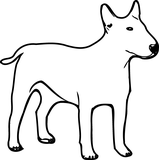

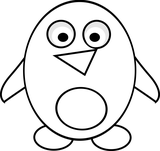

In [1]:
from PIL import Image
import numpy as np
from IPython.display import display
def get_dots(fn, size=(160,160), n_dots=500):
    # replace transparent background with white
    img = np.array(Image.open(fn).convert('RGBA'))
    img[img[:,:,3]==0]=[255,255,255,255]
    img = Image.fromarray(img).convert('L')
    img.thumbnail(size, Image.ANTIALIAS)
    display(img)
    # Use the image as a probability distribution
    a = 255 - np.array(img)
    prob = (a/a.sum()).ravel()
    # sampling from coordinate
    y, x = np.unravel_index(np.random.choice(a.size, n_dots, replace=False, p=prob), a.shape)
    return (x, size[1]-y-1)
dog = get_dots("img/drunken-duck-bulli-outline-2400px.png")
penguin = get_dots("img/penguin-line-art-jesusfreak210-Penguin-800px.png")

let's plot the data

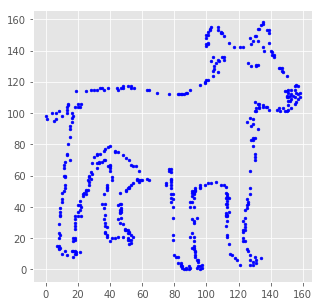

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

plt.figure(figsize=(5,5))
plt.scatter( *dog,  c='b', s=8);

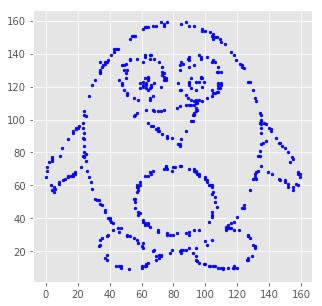

In [3]:
plt.figure(figsize=(5,5))
plt.scatter( *penguin, c='b', s=8);

## Step 2: Manipulate the statistics
These datasets have very different statistics

for the dog dataset:

In [4]:
import scipy
import scipy.stats
def show_statistics(x, y):
    print("""X Mean: {}
X SD: {}
Y Mean: {}
Y SD: {}
Corr.: {}
""".format(x.mean(), x.std(), y.mean(), y.std(), 
           scipy.stats.pearsonr(x, y)[0]))
show_statistics(*dog)

X Mean: 78.702
X SD: 46.07729588419876
Y Mean: 67.82
Y SD: 44.55454634490177
Corr.: 0.3375295756717091



For the penguin dataset

In [5]:
show_statistics(*penguin)

X Mean: 79.61
X SD: 37.12963641082417
Y Mean: 82.48
Y SD: 43.443498938276136
Corr.: -0.019533783548800837



It is not too difficult to manipulate the statistics without changing the semantic of the image. For example, means can be changed by translation, correlations can usually changed by rotation, standard deviation can be modified by stretching an axis.

We would like to manipulate the image to have standard statistics, i.e., `x mean = y means = 0`, `x sd = y sd = 1` and with 0 correlation.
Because it is usually possible to do and we don't have to manually choose the targeting statistics.

This procedure is called [whitening](https://en.wikipedia.org/wiki/Whitening_transformation), which is frequently used in machine learning to preprocess or standarize the data.

There are many ways to whitening the data, e.g, PCA, ZCA, Cholesky whitening. Some changes the image more than another. We want the  whitened image to look as like the original image as possible. 

Turns out ZCA is optimal (among linear transformations) to minimizes the total squared distance between the original and whitened variables. This is one reason ZCA is a popular choice of image preprocessing for machine learning.


See more in [Kessy et al. (2015) Optimal whitening and decorrelation](https://arxiv.org/abs/1512.00809). The ZCA_cor mentioned in paper is also worth considering, because it is optimal respect to correlation of the original and whitened variable. However, it seems the result are very similar to ZCA in our cases. Moreover, because we are going to transform from one image to another, squared distance makes sense too. 



Now, let's ZCA our dogs and penguins.

In [6]:
def ZCA(X):
    """ZCA whitening
        adapt from keras source code, 
        https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py
    """
    X = (X - X.mean(axis=0))
    Σ = X.T @ X / X.shape[0]
    U, Λ, _ = np.linalg.svd(Σ)
    principal_components = U @ np.diag(1./np.sqrt(np.abs(Λ))) @ U.T
    return X @ principal_components


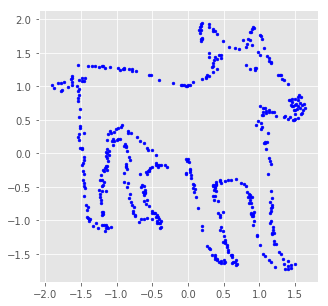

X Mean: -7.105427357601002e-18
X SD: 1.0000000000000002
Y Mean: 1.474376176702208e-16
Y SD: 1.0000000000000004
Corr.: 4.725109192804663e-16



In [7]:
dog0 = ZCA(np.float64(dog).T)
plt.figure(figsize=(5,5))
plt.scatter( *dog0.T,  c='b', s=8)
plt.show()
show_statistics(*dog0.T)

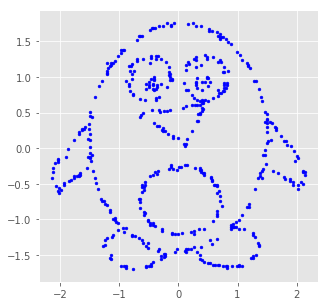

X Mean: 1.2434497875801754e-17
X SD: 1.0000000000000007
Y Mean: -8.526512829121202e-17
Y SD: 0.9999999999999997
Corr.: -2.309263891220325e-17



In [8]:
penguin0 = ZCA(np.float64(penguin).T)
plt.figure(figsize=(5,5))
plt.scatter( *penguin0.T, c='b', s=8)
plt.show()
show_statistics(*penguin0.T)

The differences can be easily spotted, but it works as expected and I am happy with the result.

## Step 3: Transform from one image to another
Now we only need to transfom a dataset into another. The easiest way to do is just doing linear interpolation: randomly pairing points between the source and target datasets, and points moves along the straight line from source to target. It may not visually amaze anyone but it should work.

About the statistics, we can simply ZCA each frame along the transition. 

But we would like the transformation to be more rational feel, not just some random moving.  One way to do that is to search the "minimum movement". That is, we find a way to move points from one dataset set to another with mimimum effort(e.g. total moving distance). 

This problem can be viewed as [minimum weight bipartite matching](https://en.wikipedia.org/wiki/Minimum-cost_flow_problem#Minimum_weight_bipartite_matching) problem in graph theory. It is indeed an important special case that the graph are equiped with plane euclidean distance.

It is also the earth mover distance: the minimum cost of turning one pile into the other. Also called as "Wasserstein metric". featured in the  deep generative algorithm [Wasserstein GAN](https://arxiv.org/abs/1701.07875) by Arjovsky et al.

`scipy` provide a function `scipy.optimize.linear_sum_assignment` to find the minimum weight matching, which is a nontrivial job to do. The pairwise distance between two dataset can be easily computed using `numpy` and elementary linear algebra, but `scipy` also conveniently proved `scipy.spatial.distance.cdist` to do the task.





In [9]:
import time
t0 = time.time()
# compute pairwise distance between the dog and the penguin
C = scipy.spatial.distance.cdist(dog0, penguin0)
print("done C", time.time()-t0)

# find the optimal matching, this might take 10~20 seconds
dog_idx, penguin_idx = scipy.optimize.linear_sum_assignment(C)
print("done", time.time()-t0)

done C 0.0044400691986083984
done 27.968473434448242


Rearrange the data to match each other.

In [10]:
dog1 = dog0[dog_idx]
penguin1 = penguin0[penguin_idx]

Plot dog -> penguin vectors 

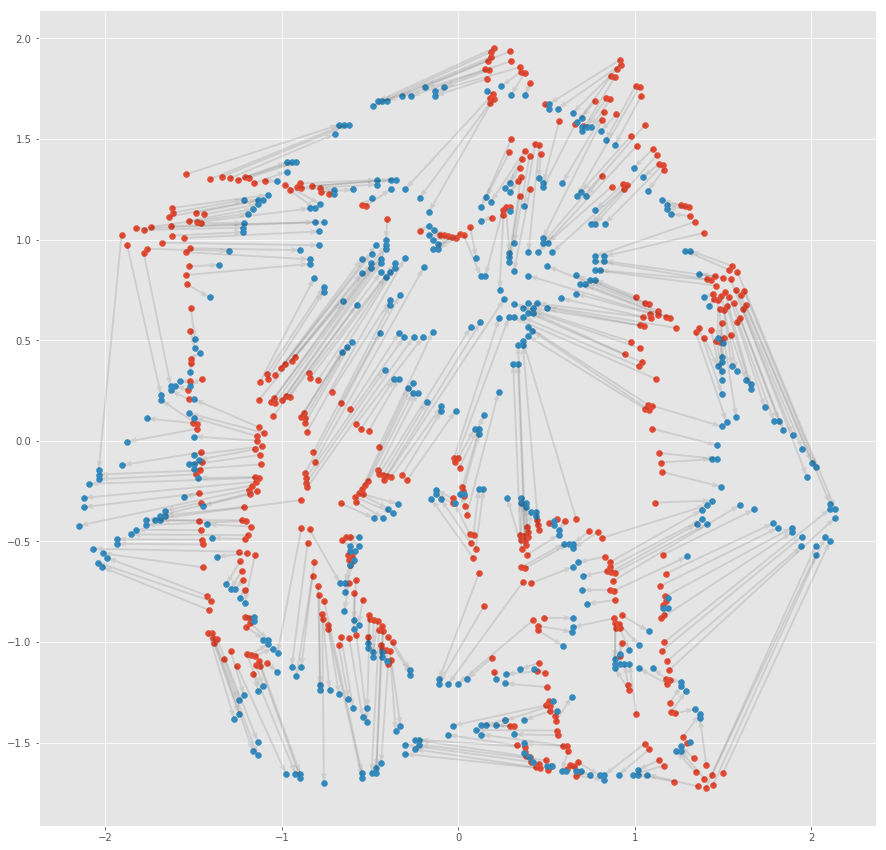

In [11]:
V = penguin1 - dog1
plt.figure(figsize=(15,15))
plt.scatter(*dog1.T)
plt.scatter(*penguin1.T)
plt.quiver(*dog1.T, *V.T, alpha=0.1, 
           units='xy', scale_units="xy", 
           scale=1, width=0.01, angles='xy');

## Step 4: Animation
All math works are done, we only need to draw the animation. 

First we interpolate two matched datasets.

In [12]:
f = scipy.interpolate.interp1d([0,1], [dog1, penguin1], axis=0)

Set up matplotlib animation and the base graph

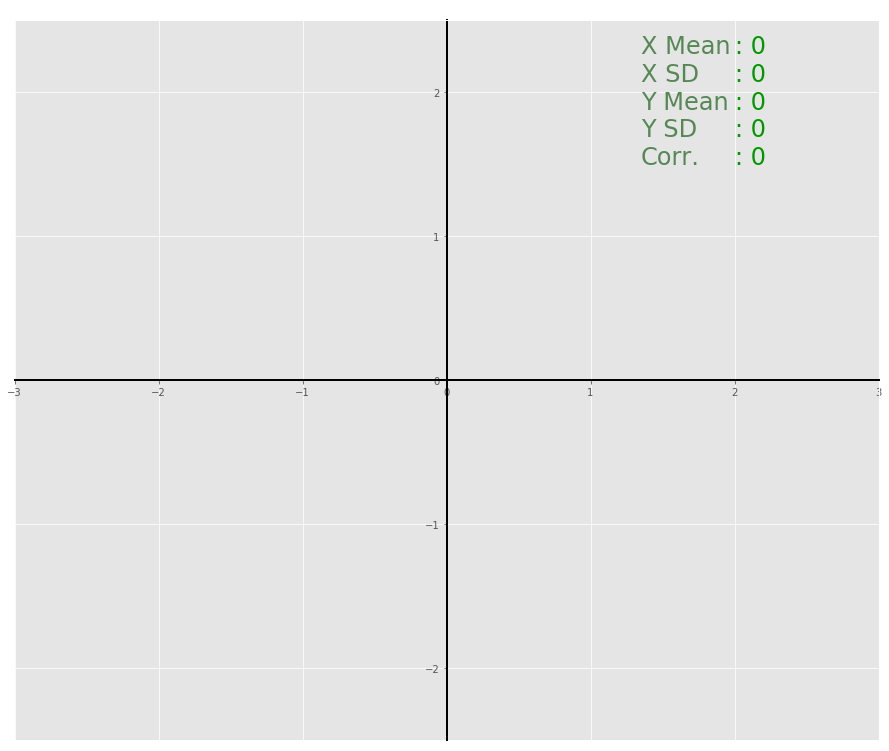

In [13]:
from matplotlib import animation, rc
rc('animation', html='html5')
fig = plt.gcf()
fig.set_size_inches(12,10)
plt.xlim(-3, 3)
plt.ylim(-2.5,2.5)
fig = plt.gcf()
scatters = plt.scatter([],[], alpha=0.7, color='blue')
label_text = plt.text(1.35,1.5,"""
X Mean
X SD  
Y Mean
Y SD 
Corr.""", size=24, color="#558855")

stat_text = plt.text(2.,1.5,"""
: 0
: 0
: 0
: 0
: 0""",size=24, color="#009900")
plt.subplots_adjust(top = 1,  right = 1, bottom=0, left=0, hspace=0, wspace=0)
ax = plt.gca()
ax.spines['left'].set_position('center')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_position('center')
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.margins(0,0)
# plt.ioff() # if you don't want to see the empty graph

In [14]:
# an helper function to see matplotlib animation with ipywidgets
# helpful for adjusting the plot
import ipywidgets
from IPython.display import display
import time
from io import BytesIO
def show_anim(anim, loops=1):
    img=ipywidgets.Image(width=800)
    display(img)
    for i in range(loops):
        target_time = time.time() + anim._interval/1000
        for d in anim.new_saved_frame_seq():    
            anim._draw_next_frame(d, blit=False)
            with BytesIO() as bio:
                fig.savefig(bio, format="png")
                img.value = bio.getvalue()
            now = time.time()
            if target_time > now:
                time.sleep(target_time-now)
            target_time += anim._interval/1000

We setup a function and use matplotlib's FuncAnimation

In [15]:
def animate(tick):    
    X = f(tick/30)
    X = ZCA(X)
    scatters.set_offsets([X])    
    stat_text.set_text("""
: {:8.5f}
: {:8.5f}
: {:8.5f}
: {:8.5f}
: {:8.5f}""".format(X[:,0].mean(), 
           X[:,0].std(), 
           X[:,1].mean(), 
           X[:,1].std(), 
           scipy.stats.pearsonr(X[:,0], X[:,1])[0]))
    return [scatters, stat_text]
anim = animation.FuncAnimation(fig, animate, frames=30, interval=1000/30, blit=True)

Viewed it as an HTML5 video

In [16]:
# can also use our helper if you have ipywidgets installed
# show_anim(anim, loops=3)
# it is useful for checking result because longer html5 video takes long time to encode
# but this animation is very short, so it can be encoded very quickly
anim

We collect a few black white drawings from https://openclipart.org/ in the img/ folder. 

Compose them together into a video loop using the method above.

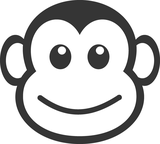

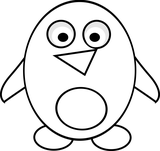

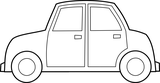

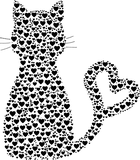

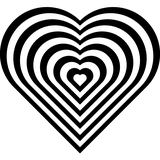

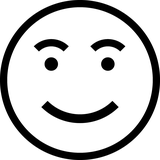

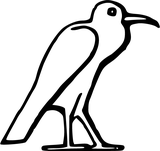

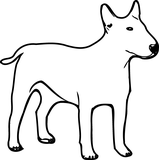

In [17]:
# load and process all images 
import glob
import random
img_files = glob.glob("img/*.png")
random.shuffle(img_files)
img_list = [ZCA(np.float64(get_dots(f)).T) for f in img_files]
# apend the first one at the end because we want it to be a loop
img_list.append(img_list[0])

In [18]:
# compute all interpolation functions, this will take several minutes.
funcs = []
for s, t in zip(img_list[:-1], img_list[1:]):    
    t0 = time.time()
    C = scipy.spatial.distance.cdist(s, t)**2
    # this might take 10~60 seconds
    s_idx, t_idx = scipy.optimize.linear_sum_assignment(C)
    funcs.append(scipy.interpolate.interp1d([0,1], [s[s_idx], t[t_idx]], axis=0))
    print("done", time.time()-t0)

done 28.5096116065979
done 22.62716794013977
done 35.64913988113403
done 23.780082941055298
done 23.869417667388916
done 31.18822956085205
done 28.728618383407593
done 29.146002769470215


Construct the animation

In [25]:
def animate(tick):
    if tick%60 < 20:
        X = img_list[tick//60]
    else:
        f = funcs[tick//60]
        X = f((tick%60-20)/40)
        X = ZCA(X)
    scatters.set_offsets([X])
    stat_text.set_text("""
: {:8.5f}
: {:8.5f}
: {:8.5f}
: {:8.5f}
: {:8.5f}""".format(X[:,0].mean(), 
           X[:,0].std(), 
           X[:,1].mean(), 
           X[:,1].std(), 
           scipy.stats.pearsonr(X[:,0], X[:,1])[0]))
    return [scatters, stat_text]
anim = animation.FuncAnimation(fig, animate, frames=60*len(funcs), interval=1000/30, blit=True)

In [20]:
# Encoding the video might take minutes
anim

In [22]:
anim.save('statistics.mp4')